<h2> Reduced Basis Methods for the Helmholz Equation </h2>

We want to create a reduced basis space for the Helmholz equation
\begin{equation}
    \Delta u - \omega^2u = f
\end{equation}

defined on a two dimensional domain $\Omega$. It has the Galerkin formulation in the finite element space $V_h$. Find an $u_h$ so that

\begin{equation}
    \int_{\Omega} \nabla u_h \nabla v_h \text{dx} - \omega^2 \int_{\Omega} u_hv_h \text{dx} - i\omega \int_{\partial \Omega} u_hv_h \text{ds} = \int_{\Omega} fv_h \text{dx}
\end{equation}

holds for all $v_h \in V_h$. We can write this as an equation of bilinearforms 

\begin{equation}
    k(u_h, v_h) - \omega^2 m(u_h, v_h) - i\omega r(u_h,v_h)= \int_{\Omega} fv_h \text{dx}  \tag{1}
\end{equation}

where $r$ only exists if we want Robin boundary conditions, otherwise $r(u,v) \equiv 0$. To get Dirichlet boundaries, we choose our test functions $v$ from the Sobolev space $H_0^1(\Omega)$ and Neumann boundaries are enforced for $v \in H^1(\Omega)$. 


<h3> The reduced basis method </h3>

In a nutshell the idea of creating a reduced basis space is to choose a so called snapshot of $N$ parameters $ \{ \omega_1, .., \omega_N \} $ for which we solve the system $(1)$. By doing so we get linearly independent snapshot solutions $\{u_h^1, .., u_h^N\}$. The space 
\begin{equation}
V_N := \overline{\text{span}\{u_h^1, .., u_h^N\}}
\end{equation}
is a linear subspace of $V_h$. To approximate a solution for an arbitrary $\omega$ we now have to solve the system $(1)$ only for $v_N \in V_N$, which is computationally way less expensive than solving the original system. 

<h3> Generate a Reduced Basis Space </h3>

We first need to import some libraries and then we write a little python class. 

The input parameter for the class is the finite element space and a coefficient function $f$. 

In [1]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from ngsolve import *
from netgen.geom2d import unit_square


import numpy as np
import scipy
import math
import time

from ngsolve.webgui import Draw

class ReducedBasis:
    
    def __init__(self, fes, f):
        self.setSpace(fes, f)
        self.logging = True

The `setSpace` and `reset` functions just (re-)set some parameters we will need later. 

In [2]:
class ReducedBasis(ReducedBasis):
    
    ## TODO: decide if biliner forms or space should be given to construct the class

    def setSpace(self, fes, func):

        self.fes = fes
        
        # assume robin bnd if fes is complex
        if fes.is_complex:
            self.robin = True
        else:
            self.robin = False
        

        # set (bi-)linear forms and matrices
        self.omega = Parameter(0)
        
        ##########################################
        ## TODO: implement the boundary thing in a better way
        u,v =self.fes.TnT()
        self.a = BilinearForm(self.fes)
        self.a += (grad(u)*grad(v) - self.omega*self.omega *u*v) * dx
        # what happens per default if "robin" doesn't exist as boundary?
        if self.robin:
            if 'robin' in self.fes.mesh.GetBoundaries():
                self.a += -1j*self.omega*u*v*ds (definedon=self.fes.mesh.Boundaries("robin"))
            else:
                self.a += -1j*self.omega*u*v*ds
        self.a.Assemble()
        self.a.Assemble()
        ##########################################
        
        # store ainv for better performance
        self.ainv = self.a.mat.Inverse(self.fes.FreeDofs(), inverse="sparsecholesky")

        self.f = LinearForm(self.fes)
        self.f += func * v * dx
        self.f.Assemble()
         

        self.k = BilinearForm(self.fes)
        self.k += grad(u)*grad(v)*dx
        self.k.Assemble()
        rows,cols,vals = self.k.mat.COO()
        self.K_orig = scipy.sparse.csr_matrix((vals,(rows,cols)))

        self.m = BilinearForm(self.fes)
        self.m += u*v * dx
        self.m.Assemble()
        rows,cols,vals = self.m.mat.COO()
        self.M_orig = scipy.sparse.csr_matrix((vals,(rows,cols)))

        if self.robin:
            self.r = BilinearForm(self.fes)
            if 'robin' in self.fes.mesh.GetBoundaries():
                self.r += u*v*ds (definedon=self.fes.mesh.Boundaries("robin"))
            else:
                self.r += u*v*ds
            self.r.Assemble()
            rows,cols,vals = self.r.mat.COO()
            self.R_orig = scipy.sparse.csr_matrix((vals,(rows,cols)))
    

        # initialize grid functions
        self.gfu = GridFunction(self.fes)
        self.drawu = GridFunction(self.fes)

        # temporary ngsolve vectors
        self.__bv_tmp = self.k.mat.CreateColVector()
        self.__bv_tmp2 = self.k.mat.CreateColVector()
        self.__gf_tmp = GridFunction(self.fes)
        
        
        self.__proj = Projector(self.fes.FreeDofs(), True)
        # compute norm of f
        self.__bv_tmp.data = self.__proj*self.f.vec
        self.f.vec.data = self.__bv_tmp.data
        self.normf = Norm(self.__bv_tmp)**2
        
        
        self.reset()

    
    def reset(self):
        # reset dynamically updated parameters
        self.K_red = None
        self.M_red = None
        self.F_red = None
        self.R_red = None
        self.sol = []
        self.__V = None  # snapshot solutions
        self.__snapshots_updated = True
        self.__snapshots = [] # snapshot parameters
        self.__indices = []


Next we can create a function that takes a list of omegas and sets them as snapshots. To have the possibility to dynamically expand our reduced basis later on, we will expand the list of snapshot parameters instead of resetting them if `reset==False`. We will also add a get function. 

In [3]:
class ReducedBasis(ReducedBasis):

    def setSnapshots(self, new_snapshots, reset = True, compute_RB = True):
        
        # TODO: check that snapshots do not already exist
        if len(self.__snapshots) > 0 and not reset:
            if self.logging: print("append snapshots with {}".format(new_snapshots))
            self.__snapshots = np.append(self.__snapshots, np.array(new_snapshots))
        else:
            if self.logging: print("set snapshots and reset basis")
            self.__snapshots = np.array(new_snapshots)
            self.__V = None

        self.__snapshots_updated = True
        self.__update_res_mat = True

        # store smallest and biggest snapshot parameter
        self.omega_min = min(self.__snapshots)
        self.omega_max = max(self.__snapshots)

        # store indices of snapshots in ascending order
        tmp = self.__snapshots
        zip_to_sort = list(zip(tmp, range(len(tmp))))
        sorted_zip = sorted(zip_to_sort, key=lambda x: x[0], reverse=False)
        self.__indices = [tup[1] for tup in sorted_zip]

        if compute_RB:
            self.__computeRB()

    def getSnapshots(self):
        return self.__snapshots[self.__indices]

Let $n$ be the dimension of the original space $V_h$. The snapshot solutions $\{u_h^1, .., u_h^N\}$ could be used directly as basis functions for $V_N$. However we prefer the matrix $V \in \mathbb{C}^{n\times N} $ that contains the coefficients of the reduced basis functions $\{\zeta^1, .., \zeta^N\}$  to be as pretty as possible. Therefore we make sure that the coefficient vectors of the $\zeta_i$ form an ortonormal system respective the Euklidean norm. This we achieve by performing a QR-decomposition and only using the Q part. 


We now solve the equation $(1)$ in the original space for the new snapshots. If the matrix $V$ already contains some basis functions, we extend the basis. 

In [4]:
class ReducedBasis(ReducedBasis):
    
    def __computeRB(self):


        if self.logging: print("compute Reduced Basis")

        if len(self.__snapshots) == 0:
            if self.logging: print(""" no snapshots given, please call 'instance.setSnapshots' first""")
            return
        
        dim_orig = len(self.gfu.vec)
        dim_red = len(self.__snapshots)

        if self.robin:
            V_tmp = np.zeros((dim_orig, dim_red), dtype=complex )
        else:
            V_tmp = np.zeros((dim_orig, dim_red))

        # extend basis if it already exists
        try: 
            existing_basis_len = len(self.__V)
            ## TODO: if Numpy interface working get rid of for loop
            for i in range(existing_basis_len):
                V_tmp[:,i] = self.__V[i].FV().NumPy()
#             V_tmp[:,0:existing_basis_len] = self.__V
            self.__V.Expand(dim_red-existing_basis_len)
            if self.logging: print("extend reduced basis")

        except:
            existing_basis_len = 0
            self.__V = MultiVector(self.__bv_tmp, dim_red)


        with TaskManager():

            for n in range(0+existing_basis_len, dim_red):
                _omega = self.__snapshots[n]
                
                # compute FEM solution for parameter _omega
                self.omega.Set(_omega)
                self.a.Assemble()

                self.ainv.Update()
                self.gfu.vec.data = self.ainv * self.f.vec

                V_tmp[:,n] = self.gfu.vec.FV().NumPy()        


            # do QR-decomposition 
            q, r = np.linalg.qr(V_tmp)
            V_tmp = V_tmp.dot(np.linalg.inv(r))
            

            # rearange V and snapshots due to the order of the snapshots
            ## TODO: if Numpy interface working get rid of loop
            for i in range(dim_red):
                self.__V[i].FV().NumPy()[:] = V_tmp[:, self.__indices[i]]
                

            # set system in reduced basis space
            
             ## TODO: get rid of that if conversion to matrix implemented
            V_tmp = V_tmp[:, self.__indices]
            self.K_red = np.transpose(V_tmp).dot(self.K_orig.dot(V_tmp))
            self.M_red = np.transpose(V_tmp).dot(self.M_orig.dot(V_tmp))
            self.F_red = np.transpose(V_tmp).dot(self.f.vec.data)

            if self.robin:
                self.R_red = np.transpose(V_tmp).dot(self.R_orig.dot(V_tmp))

            self.__snapshots_updated = False
            self.__snapshots = self.__snapshots[self.__indices]
            self.__indices = range(dim_red)
            
            if self.logging: print("finished computing Reduced Basis")
                


To look at the solutions of the reduced system, we want to implement a draw function, that takes a parameter $\omega$, computes the reduced solution and displays it in the ngsolve webgui.

In [5]:
class ReducedBasis(ReducedBasis):
    
    def draw(self, omega, redraw=False):
        
        if self.__snapshots_updated:
            self.__computeRB()
        
        # compute reduced basis
        
        ## TODO: make LU decomposition once  (for M and K) and use np.linalg.solve_triangular
        ## (vorwaerts- und rueckwaertssubstitution)
        if self.robin:
            Ainv = np.linalg.inv(self.K_red-omega*omega*self.M_red-1j*omega*self.R_red)
        else:
            Ainv = np.linalg.inv(self.K_red-omega*omega*self.M_red)

        red_sol_vec = np.matmul(Ainv, self.F_red)
        
#         self.drawu.vec.FV().NumPy()[:] = self.__V.dot(red_sol_vec)[:]
        v = Vector(red_sol_vec.tolist())
#         v.FV().NumPy()[:] = red_sol_vec
        
        ## TODO: implement 
        self.drawu.vec.data = self.__V * v
        if self.logging: print("omega: {}, norm of solution: {}".format(omega, Integrate ( Conj(self.drawu)*(self.drawu), self.fes.mesh)))
        # draw solution
        if not redraw:
            self.scene = Draw(self.drawu)
        else:
            self.scene.Redraw()
#             Redraw()


To test the implementation so far, we define an H1-FEM space on the unit square with dirichlet boundary values. To compute the first set of snapshot solutions we choose the parameters $\omega \in \{0, .., 20\}$. Subsequently we create a slider to visualize the reduced solutions for a set of omegas. 

<h3> Compute the residual </h3>

Let $M, K, R \in \mathbb{C}^{nxn}$ and $F \in \mathbb{C}^{n}$ be the matrices (respectively the vector) corresponding to the bilinear forms in (1). A solution of the reduced system can be written as $Vu = \sum_{j = 1}^{N}u_j\zeta_j \in V_h$ with coefficient vector $u = (u_1, .., u_N)$. Therefore a norm of the residual can be defined as $|| (K-\omega^2 M -i\omega R)Vu -F||$.


By squaring and rearranging the therm above we get a measure <span style="color:red">(Anm: ich meine nicht Maß im mathematischen Sinne. Was wäre ein besseres Wort dafür?)</span> for the residual

\begin{equation}
\begin{split}
    \text{res}(\omega) :&= || (K-\omega^2 M -i\omega R)Vu -F||_2^2 \\
    &= || (K-\omega^2 M -i\omega R)Vu||_2^2 + 2\text{Re} \langle (K-\omega^2 M -i\omega R)Vu , F \rangle + ||F||_2^2 \\
    &= \sum_{j = 1}^N \sum_{k = 1}^N u_j \overline{u_k}\langle (K-\omega^2 M -i\omega R)\zeta_j, (K-\omega^2 M -i\omega R)\zeta_k \rangle + \sum_{j = 1}^N u_j \langle (K-\omega^2 M -i\omega R)\zeta_j, F \rangle  + || F||^2 \\
    & = \overline{u^T}Au - 2\text{Re} A_F u + || F||^2
\end{split} 
\end{equation}
where 
\begin{equation}
\begin{split}
    (A)_{jk} = ~ & \langle K\zeta_j, K\zeta_k \rangle -\omega^2 \langle M\zeta_j, K\zeta_k \rangle - i\omega \langle R\zeta_j, K\zeta_k \rangle \\
       & - \omega^2 \langle K\zeta_j, M\zeta_k \rangle + \omega^4 \langle M\zeta_j, M\zeta_k \rangle + i\omega^3 \langle R\zeta_j, M\zeta_k \rangle \\
       &-i\omega \langle K\zeta_j, R\zeta_k \rangle + i \omega^3 \langle M\zeta_j, R\zeta_k \rangle + \omega^2 \langle R\zeta_j, R\zeta_k \rangle.
\end{split}
\end{equation}
and 
\begin{equation}
    (A_F)_{j} = \langle K\zeta_j, F \rangle - \omega^2 \langle M\zeta_j, F \rangle - i\omega \langle R\zeta_j, F \rangle.
\end{equation}

Now we can implement a function that build all the necessary matrices. 

In [6]:
def myinner(A,B):
    return np.complex(np.inner(np.transpose(A), np.transpose(B)))

In [7]:
class ReducedBasis(ReducedBasis):
    
    def __computeResMat(self):
        
        self.__update_res_mat = False
        dim = self.K_red.shape
        
        if self.robin:
            npdtype = 'complex'
        else:
            npdtype = 'longdouble'


        
        ## TODO: test with ngsolve operations
        # TODO: think about boundaries
        
        V_np = np.zeros((len(self.__V[0]), len(self.__V)), dtype=npdtype)
        for i in range(len(self.__V[0])):
            for j in range(len(self.__V)):
                V_np[i,j] = self.__V[j][i]
        k_zeta_np = self.K_orig.dot(V_np)
        m_zeta_np = self.M_orig.dot(V_np)

#         k_zeta = MultiVector(self.__bv_tmp, dim[0])
#         m_zeta = MultiVector(self.__bv_tmp, dim[0])
#         tmp = MultiVector(self.__bv_tmp, dim[0])
                
#         tmp.data = self.k.mat * self.__V
#         k_zeta.data = self.__proj * tmp
        
#         tmp.data = self.m.mat * self.__V
#         m_zeta.data = self.__proj * tmp
        
        keys = ['kk', 'mm', 'mk']
        
        if self.robin:
            r_zeta_np = self.R_orig.dot(V_np) #np.zeros(k_zeta_np.shape, dtype="complex")
            keys += ['rr', 'rm', 'rk']
            

        self.__res_mat = {} # kk, mm, km, rr, rm, rk
        self.__np_res_mat = {}
        
        for key in keys:
            self.__np_res_mat[key] = np.zeros(dim, dtype = npdtype)
#             self.__res_mat[key] = Matrix(dim[0], dim[1], complex=self.robin)

            if list(key)[0] == list(key)[1]:
                self.__np_res_mat['{}f'.format(list(key)[0])] = np.zeros(dim[0], dtype = npdtype)
#                 self.__res_mat['{}f'.format(list(key)[0])] = Vector(dim[0], complex= self.robin)
        
        
        
        # TODO: without for loop (parallel)
        for j in range(dim[0]):
            ## maybe use hermitian property for hermitian matrices
            # f 
            for key in keys:
                if list(key)[0] == list(key)[1]:
#                     self.__res_mat['{}f'.format(list(key)[0])][j] = eval(
#                         "InnerProduct ({}_zeta[{}], self.f.vec.data)".format(list(key)[0], j))
                    self.__np_res_mat['{}f'.format(list(key)[0])][j] = eval("myinner({}_zeta_np[:,{}], self.f.vec.FV().NumPy())".format(list(key)[0], j))
            for k in range(dim[0]):
                for key in keys:
#                     self.__res_mat[key][j,k] = eval(
#                         "InnerProduct ({}_zeta[{}], {}_zeta[{}])".format(list(key)[0], j, list(key)[1], k))
                    self.__np_res_mat[key][j,k] = eval("myinner({}_zeta_np[:,{}], {}_zeta_np[:,{}])".format(list(key)[0], j, list(key)[1], k))


We now want to plot the norms and residuals of the solutions for a large set of different omegas. Therefore we extend our class by a function that takes a vector of omegas and returns the corresponding values (norm and/or residual).

In [8]:
def myinner(A,B):
    return np.complex(np.inner(np.transpose(A), np.transpose(B)))

In [13]:
class ReducedBasis(ReducedBasis):
    
    def computeValues(self, param, residual=True, norm=True, cheap = True):
        
        ret_val = []

        if self.__snapshots_updated:
            self.__computeRB()
        
        
        if residual and norm: 
            if self.logging: print("compute residual and norm")
        elif residual: 
            if self.logging: print("compute residual")
        elif norm: 
            if self.logging: print("compute norm")
        else: return
        
        norm_ret = []
        residual_ret = []

        
        with TaskManager():

            for _omega in param:
                
                ## TODO: make LU decomposition once  (for M and K) and use np.linalg.solve_triangular
                ## (vorwaerts- und rueckwaertssubstitution)
                ## or change to ngsolve operations
                if self.robin:
                    Ainv = np.linalg.inv(self.K_red-_omega*_omega*self.M_red-1j*_omega*self.R_red)
                else:
                    Ainv = np.linalg.inv(self.K_red-_omega*_omega*self.M_red)
                red_sol_vec = Vector(np.matmul(Ainv, self.F_red).tolist())
                
                
                if norm:

    #                 self.__gf_tmp.vec.FV().NumPy()[:] = self.__V.dot(red_sol_vec) 
                    self.__gf_tmp.vec.data = self.__V * red_sol_vec
#                     self.__gf_tmp.vec.data = self.__V * red_sol_vec


                    # imaginary part is not exactly 0 due to numerical errors
                    nof = np.real(Integrate(self.__gf_tmp*Conj(self.__gf_tmp), self.fes.mesh))
                    norm_ret += [nof]

                if residual:   
                    
                    if cheap:
                        if self.__update_res_mat:
                            self.__computeResMat()
                        ## TODO: how to conjugate a matrix pointwise
#                         A = (self.__res_mat['kk']- _omega**2*(self.__res_mat['mk']+
# #                             Conj(self.__res_mat['mk']))+ _omega**4*(self.__res_mat['mm']))
#                         A = (self.__res_mat['kk']- self.__res_mat['mk']*_omega**2*2+self.__res_mat['mm']*_omega**4)
#                         A_F = self.__res_mat['kf']-self.__res_mat['mf']*_omega**2
        
                        A_np = (self.__np_res_mat['kk']- _omega**2*(self.__np_res_mat['mk']+self.__np_res_mat['mk'])+_omega**4*self.__np_res_mat['mm'])
                        A_F_np = self.__np_res_mat['kf']-_omega**2*self.__np_res_mat['mf']
                                
                        
                        if self.robin:
                            A_np += (-1j*_omega*(self.__np_res_mat['rk']+self.__np_res_mat['rk'])
                                 + 1j*_omega**3*(self.__np_res_mat['rm']+self.__np_res_mat['rm'])
                                 - _omega**2*self.__np_res_mat['rr'])
                            A_F_np -= 1j*_omega*self.__np_res_mat['rf']
                        #print(type(self.__np_res_mat['rk'][0,0]))    
                        tmp = red_sol_vec.NumPy()
                        #print(tmp)
                        res_np = myinner(tmp, A_np.dot(tmp)) - 2*myinner(tmp,A_F_np) + self.normf
#                         res = InnerProduct(red_sol_vec, A * red_sol_vec) - 2*np.real( InnerProduct(red_sol_vec, A_F)) + self.normf
                        residual_ret += [abs(res_np)]

                    else:
                        if not norm: self.__gf_tmp.vec.data = self.__V * red_sol_vec
                    
                        self.__bv_tmp.data = self.k.mat*self.__gf_tmp.vec - _omega*_omega*self.m.mat*self.__gf_tmp.vec - self.f.vec
                        
                        if self.robin:
                            self.__bv_tmp.data += -1j*_omega*self.r.mat*self.__gf_tmp.vec

#                         self.__bv_tmp2.data = self.__proj*self.__bv_tmp
                        res = Norm(self.__bv_tmp)**2
                    
                        residual_ret += [res]
                    
                    
        if self.logging: print("finished computing values")
        if norm and (not residual): return norm_ret
        if residual and (not norm): return residual_ret
        if norm and residual: return norm_ret, residual_ret
    

Again we define an instance of our now updated class. Afterwards we can plot norm and residuals for a set of random omegas. 

In [14]:
mesh = Mesh(unit_square.GenerateMesh(maxh=0.2))
fes = H1(mesh, order=3, complex=True)#,dirichlet="bottom|right|top|left")

x_0 = 0.6
y_0 = 0.3
func = 100*exp(-20*((x-x_0)**2 + (y-y_0)**2))

space = ReducedBasis(fes, func)
snapshots = np.array([0.5]+np.arange(1,5, 1).tolist())

space.setSnapshots(snapshots)

space.draw(space.omega_min, redraw = False)
slider_func = lambda x: space.draw(x, redraw=True)

interact(slider_func, x=widgets.FloatSlider(min=space.omega_min, max=space.omega_max, step=0.05, value=space.omega_min))

set snapshots and reset basis
compute Reduced Basis
finished computing Reduced Basis
omega: 0.5, norm of solution: (60.900290182933524-9.100260057090585e-18j)


NGSWebGuiWidget(value={'ngsolve_version': '6.2.2006-98-ge712f407', 'mesh_dim': 2, 'order2d': 2, 'order3d': 2, …

interactive(children=(FloatSlider(value=0.5, description='x', max=4.0, min=0.5, step=0.05), Output()), _dom_cl…

<function __main__.<lambda>(x)>

In [15]:

random_omegas = np.sort(np.append(np.random.uniform(space.omega_min, space.omega_max, 1000), snapshots))
norm, residual = space.computeValues(random_omegas)
res_np = residual

residual = space.computeValues(space.getSnapshots(), norm=False)
snap_np = residual

res_orig = space.computeValues(random_omegas, norm=False, cheap = False)

compute residual and norm
finished computing values
compute residual
finished computing values
compute residual
finished computing values


<IPython.core.display.Javascript object>


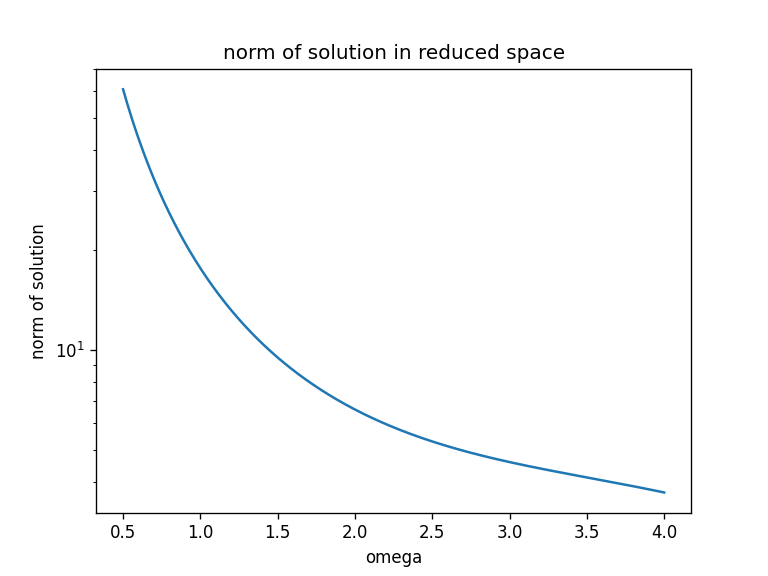

<IPython.core.display.Javascript object>


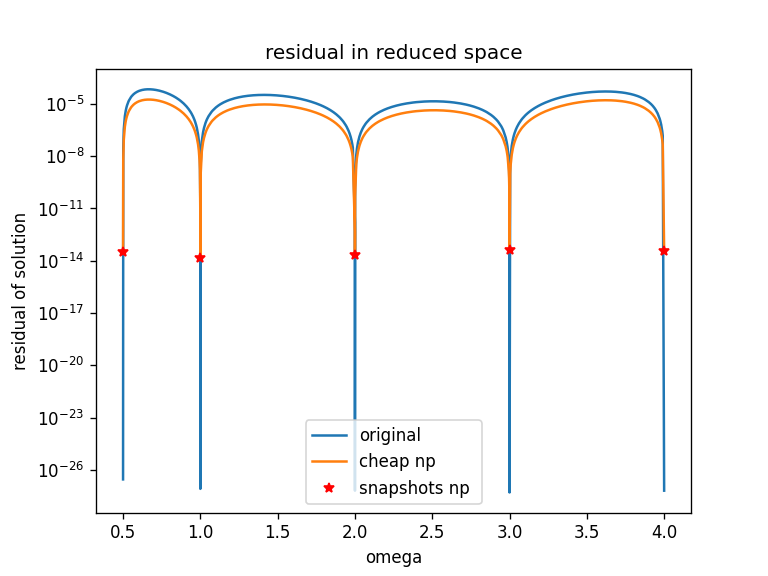

[]

In [16]:
%matplotlib notebook
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(random_omegas, norm,  '-', label = "norm")
ax.set_xlabel("omega")
ax.set_ylabel("norm of solution")
ax.set_title("norm of solution in reduced space")
plt.semilogy()

fig, ax = plt.subplots()         
ax.plot(random_omegas, res_orig , '-', label= "original")
ax.plot(random_omegas, res_np , '-', label= "cheap np")

ax.plot(space.getSnapshots(), snap_np, 'r*', label = "snapshots np ")

ax.legend()
ax.set_xlabel("omega")
ax.set_ylabel('residual of solution')
ax.set_title("residual in reduced space")
plt.semilogy()

In [ ]:
import numpy as np
from numpy import linalg as LA

In [ ]:
import numpy as np
from numpy import linalg as LA
#A = np.array([[1+1j,2+2j,3],[5+2j,8*3j,3+1j],[2+2j,3+2j,3+4j]])

omg = 1
K = np.array([[1,1,1],[2,3,1],[1,-2,0]])
M = np.array([[0,-1,1],[0,-1,0],[-1,-3,0]])
#R = np.array([[1,2,0],[2,3,1],[2,2,4]])
#u = np.array([[1+1j],[2+1j],[2-1j]])
u = np.array([[1],[2],[2]])
I = np.array([[1,0,0],[0,1,0],[0,0,1]])
V = np.array([[1,2],[1,1],[4,4]])
A = K-omg**2*M#-1j*omg*R
F = A.dot(u)
#V,r = np.linalg.qr(F)

In [ ]:
Ku = (K).dot(u)
Mu = (M).dot(u)
tmp1 = np.vdot(Ku,Ku)-omg**2*np.vdot(Mu,Ku)-omg**2*np.vdot(Ku,Mu)+omg**4*np.vdot(Mu,Mu)
c = np.vdot(F,Ku)-omg**2*np.vdot(F,Mu)
d = np.vdot(F,Ku)-omg**2*np.vdot(Mu,F)
tmp3 = np.vdot(F,F)
print(tmp1-c-d+tmp3)

# Reell orgiginal

In [ ]:
omg = 1
K = np.array([[1,1,1],[2,3,1],[1,-2,0]])
M = np.array([[0,-1,1],[0,-1,0],[-1,-3,0]])
u = np.array([[1],[2],[2]])
I = np.array([[1,0,0],[0,1,0],[0,0,1]])
V = np.array([[1,2],[1,1],[4,4]])
A = K-omg**2*M#-1j*omg*R
F = A.dot(u)

Ku = (K).dot(u)
Mu = (M).dot(u)
tmp1 = np.vdot(Ku-omg**2*Mu,Ku-omg**2*Mu)
tmp1_aus = np.vdot(Ku,Ku)-omg**2*np.vdot(Mu,Ku)-omg**2*np.vdot(Ku,Mu)+omg**4*np.vdot(Mu,Mu)
print(tmp1-tmp1_aus)
c = np.vdot(F,Ku)-omg**2*np.vdot(F,Mu)
d = np.vdot(F,Ku)-omg**2*np.vdot(Mu,F)
tmp3 = np.vdot(F,F)
print(tmp1-c-d+tmp3)

# Reell reduce

In [ ]:
omg = 1
K = np.array([[1,1,1],[2,3,1],[1,-2,0]])
M = np.array([[0,-1,1],[0,-1,0],[-1,-3,0]])
u = np.array([[1],[2],[2]])
I = np.array([[1,0,0],[0,1,0],[0,0,1]])
V = np.array([[1,2],[1,1],[4,4]])
A = K-omg**2*M#-1j*omg*R
F = A.dot(u)

u_r = np.transpose(V).dot(u)
K_r = (np.transpose(V).dot(K.dot(V)))#.dot(u_r)
M_r = (np.transpose(V).dot(M.dot(V)))#.dot(u_r)

A_r = K_r-omg**2*M_r#-1j*omg*R
F_r = A_r.dot(u_r)

Ku_r = (np.transpose(V).dot(K.dot(V))).dot(u_r)
Mu_r = (np.transpose(V).dot(M.dot(V))).dot(u_r)


tmp1 = np.vdot(Ku_r-omg**2*Mu_r,Ku_r-omg**2*Mu_r)
#tmp1_aus = np.vdot(Ku,Ku)-omg**2*np.vdot(Mu,Ku)-omg**2*np.vdot(Ku,Mu)+omg**4*np.vdot(Mu,Mu)
#print(tmp1-tmp1_aus)
c = np.vdot(F_r,Ku_r)-omg**2*np.vdot(F_r,Mu_r)
d = np.vdot(F_r,Ku_r)-omg**2*np.vdot(Mu_r,F_r)
tmp3 = np.vdot(F_r,F_r)
print(tmp1-c-d+tmp3)

# Imagenär

In [ ]:
omg = 1
K = np.array([[1,1,1],[2,3,1],[1,-2,0]])
M = np.array([[0,-1,1],[0,-1,0],[-1,-3,0]])
R = np.array([[1,2,0],[2,3,1],[2,2,4]])
u = np.array([[1+1j],[2+1j],[2-1j]])


A = K-omg**2*M-1j*omg*R
F = A.dot(u)
Ku = (K).dot(u)
Mu = (M).dot(u)
Ru = R.dot(u)

tmp = (K-omg**2*M-1j*omg*R).dot(u)-F
print(tmp)
tmp1 = np.vdot(Ku-omg**2*Mu-1j*omg*Ru,Ku-omg**2*Mu-1j*omg*Ru)

tmp1_aus = np.vdot(Ku,Ku)-omg**2*np.vdot(Mu,Ku)-omg*np.vdot(1j*Ru,Ku)-omg**2*np.vdot(Ku,Mu)+omg**4*np.vdot(Mu,Mu)+omg**3*np.vdot(1j*Ru,Ku)-omg*np.vdot(Ku,1j*Ru)+omg**3*np.vdot(Mu,1j*Ru)+omg**2*np.vdot(1j*Ru,1j*Ru)

print(tmp1,-tmp1_aus)
#tmp2 = np.vdot(Ku-omg**2*Mu-1j*omg*Ru,F)
#tmp2_aus = np.vdot(Ku,F)-omg**2*np.vdot(Mu,F)-1j*omg*np.vdot(Ru,F)
#tmp3 = np.vdot(F,Ku-omg**2*Mu-1j*omg*Ru)
#tmp4 = np.vdot(F,F)
#print(tmp1-tmp2-tmp3+tmp4)

#tmp1 = np.vdot(Ku,Ku)-omg**2*np.vdot(Ku,Mu)-1j*omg*np.vdot(Ku,Ru)-omg**2*np.vdot(Mu,Ku)
#+omg**4*np.vdot(Mu,Mu)+1j*omg**3*np.vdot(Mu,Ru)-1j*omg*np.vdot(Ku,Ru)+1j*omg**3*np.vdot(Ru,Mu)
#-omg**2*np.vdot(Ru,Ru)
#c = np.vdot(F,Ku)-omg**2*np.vdot(F,Mu)-1j*omg*np.vdot(F,Ru)
#d = np.vdot(Ku,F)-omg**2*np.vdot(Mu,F)-1j*omg*np.vdot(Ru,F)
#tmp3 = np.vdot(F,F)
#print(tmp1-c-d+tmp3)
#print(tmp1,tmp1-tmp1_aus)
#print(tmp2,tmp2_aus,tmp2-tmp2_aus)

# Imag Test

In [ ]:
v1 = np.array([[1+1j],[2+1j]])
v2 = np.array([[2+1j],[5+3j]])
v3 = np.array([[2+2j],[3+3j]])
print(np.vdot(v1+v2+v3,v1+v2+v3),np.vdot(v1,v1)+np.vdot(v1,v2)+np.vdot(v1,v3)+np.vdot(v2,v1)+np.vdot(v2,v2)+np.vdot(v2,v3)+np.vdot(v3,v1)+np.vdot(v3,v2)+np.vdot(v3,v3))

In [ ]:
print(Ku)
print("")
print(F)
print("")
print(Ku*F)
print("")
print(np.vdot(Ku,F))
print("")


In [ ]:
u_r = np.transpose(V).dot(u)
Ku_r = (np.transpose(V).dot(K.dot(V)))#.dot(u_r)
Mu_r = (np.transpose(V).dot(M.dot(V)))#.dot(u_r)
print((np.transpose(V).dot(K.dot(V))))
print(u_r)
F_r = np.transpose(V).dot(F)
print("Matrix: ",(Ku_r-omg**2*Mu_r).dot(u_r)-F_r)
tmp1 = np.vdot(Ku_r,Ku_r)-omg**2*np.vdot(Mu_r,Ku_r)-omg**2*np.vdot(Ku_r,Mu_r)+omg**4*np.vdot(Mu_r,Mu_r)
c = np.vdot(F_r,Ku_r)-omg**2*np.vdot(F_r,Mu_r)
d = np.vdot(Ku_r,F_r)-omg**2*np.vdot(Mu_r,F_r)
tmp3 = np.vdot(F_r,F_r)
print(tmp1-c-d+tmp3)
print(tmp1,-c-d,tmp3)
print(c)
print(d)
print(tmp3)

In [ ]:
print("Matrix: ",(Ku_r-omg**2*Mu_r).dot(u_r))

In [ ]:
u_r = np.transpose(V).dot(u)
Ku_r = (np.transpose(V).dot(K.dot(V)))#.dot(u_r)
Mu_r = (np.transpose(V).dot(M.dot(V)))#.dot(u_r)
Ru_r = (np.transpose(V).dot(R.dot(V)))
F_r = np.transpose(V).dot(F)


tmp = (Ku_r-omg**2*Mu_r-1j*omg*Ru_r).dot(u_r)-F_r
print(np.vdot(tmp,tmp))

In [ ]:
tmp = (K-omg**2*M-1j*omg*R).dot(u)-F
print(np.vdot(tmp,tmp))
tmp1 = np.vdot((K-omg**2*M-1j*omg*R).dot(u),(K-omg**2*M-1j*omg*R).dot(u))
tmp1 = 
tmp2 = 2*np.vdot(F,(K-omg**2*M-1j*omg*R).dot(u))
tmp3 = np.vdot(F,F)
print(tmp1-tmp2+tmp3)
#print(np.vdot((K-omg**2*M).dot(u),(K-omg**2*M).dot(u))-np.vdot(F,(K-omg**2*M).dot(u)))-np.vdot(F,(K-omg**2*M).dot(u))

In [ ]:
print(np.transpose(V).dot(K.dot(V)))

In [ ]:
#tmp = (K-omg**2*M).dot(u)-F
#print(np.vdot(tmp,tmp))
#tmp1 = np.vdot((K-omg**2*M).dot(u),(K-omg**2*M).dot(u))
#u = np.transpose(V).dot(u)
#Ku = (np.transpose(V).dot(K.dot(V))).dot(u)
#Mu = (np.transpose(V).dot(M.dot(V))).dot(u)
#F = np.transpose(V).dot(F)

#tmp2 = 2*np.vdot(F,(K-omg**2*M).dot(u))

Ku = (K).dot(u)
Mu = (M).dot(u)
tmp1 = np.vdot(Ku,Ku)-omg**2*np.vdot(Mu,Ku)-omg**2*np.vdot(Ku,Mu)+omg**4*np.vdot(Mu,Mu)
c = np.vdot(F,Ku)-omg**2*np.vdot(F,Mu)
d = np.vdot(F,Ku)-omg**2*np.vdot(Mu,F)
tmp3 = np.vdot(F,F)
print(tmp1-c-d+tmp3)
#print(np.vdot((K-omg**2*M).dot(u),(K-omg**2*M).dot(u))-np.vdot(F,(K-omg**2*M).dot(u)))-np.vdot(F,(K-omg**2*M).dot(u))

In [ ]:
print(np.linalg.solve(A,F))

In [ ]:
A_jk = np.zeros([3,3])
A_Fab = np.zeros([3,1])
A_Fba = np.zeros([3,1])
#for i in range(3):
#    A_Fab[i,0] = np.vdot(K[i],F)-omg**2*np.vdot(M[i],F)-1j*omg*np.vdot(R[i],F)
#    A_Fba[i,0] = np.vdot(F,K[i])-omg**2*np.vdot(F,M[i])-1j*omg*np.vdot(F,R[i])
#    for j in range(3):      
#        A_jk[i,j] = np.vdot(K[i],K[j])-omg**2*np.vdot(M[i],K[j])-1j*omg*np.vdot(R[i],K[j])-omg**2*np.vdot(K[i],M[j])
#        +omg**4*np.vdot(M[i],M[j])+1j*omg**3*np.vdot(R[i],M[j])-1j*omg*np.vdot(K[i],R[j])*1j*omg**3*np.vdot(M[i],R[j])
#        -omg*np.vdot(R[i],R[j])
for i in range(3):
    A_Fab[i,0] = np.vdot(K[i],F)-omg**2*np.vdot(M[i],F)
    A_Fba[i,0] = np.vdot(F,K[i])-omg**2*np.vdot(F,M[i])
    for j in range(3):      
        A_jk[i,j] = np.vdot(K[i],K[j])-2*omg**2*np.vdot(M[i],K[j])+omg**4*np.vdot(M[i],M[j])

        

In [ ]:
print(np.transpose(u).dot(A_jk.dot(u))-np.transpose(A_Fab).dot(u)-np.transpose(A_Fab).dot(u)+np.vdot(F,F))
print(np.vdot(F,F))
print(-np.vdot(A_Fab,u)-np.vdot(A_Fba,u))
print(np.transpose(u).dot(A_jk.dot(u)))

In [ ]:
A_jk.dot(u)

In [ ]:
print(LA.norm(F))
print(np.vdot(F,F))

In [ ]:
A_F.dot(np.transpose(u))

In [ ]:
A_F

In [ ]:
u

In [ ]:
np.conj(u)

In [ ]:
K[i]

In [ ]:
A_Fab[1,0]